# Navigation

---

This notebook is the implementation of the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893). The Unity ML-Agents environment is used for this project.

## 1. Start the Environment

We begin by importing necessary packages.  

In [1]:
# import modules
from unityagents import UnityEnvironment
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

import random
from collections import namedtuple, deque

## 2. Set Hyper Parameters

In [2]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 3. Show Environment Information

The environment info can be displayed by this function...

In [3]:
def ShowEnvInfo(env, brain_name):
    # reset the environment
    env_info = env.reset(train_mode=True)[brain_name]
    
    # number of agents in the environment
    print('Number of agents:', len(env_info.agents))
    
    # number of actions
    action_size = brain.vector_action_space_size
    print('Number of actions:', action_size)
    
    # examine the state space 
    state = env_info.vector_observations[0]
    print('States look like:', state)
    state_size = len(state)
    print('States have length:', state_size)
    
    return state_size, action_size


Next, we will start the banana environment, which is located at 

**Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
 # open environment
env = UnityEnvironment(file_name="./Banana_Windows_x86_64/Banana.exe")
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

state_size, action_size= ShowEnvInfo(env, brain_name)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


## 4. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [0.         1.         0.         0.         0.16895212 0.
 1.         0.         0.         0.20073597 1.         0.
 0.         0.         0.12865657 0.         1.         0.
 0.         0.14938059 1.         0.         0.         0.
 0.58185619 0.         1.         0.         0.         0.16089135
 0.         1.         0.         0.         0.31775284 0.
 0.        ]
States have length: 37


## 5. Q Network Implementation

Both the target and local networks use the same architecture, which is listed below:

- a 64-node fully-connected hidden layer
- a relu layer
- a 64-node fully-connected hidden layer
- a relu layer
- an output layer 

In [6]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        "*** YOUR CODE HERE ***"
        self.fc1= nn.Linear(state_size, 64)
        self.fc2= nn.Linear(64,64)
        self.fc3= nn.Linear(64,action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x= self.fc1(state)
        x= F.relu(x)
        x= self.fc2(x)
        x= F.relu(x)
        x= self.fc3(x)
        return x

## 6. Replay Buffer Implementation

An experience replay buffer with a size of 1e5 was used. The sampling method is random
sampling. 

In [7]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

## 7. DQN Agent Implementation

A deep Q-learning network (DQN) algorithm was used in this project. A simple fully-connected 
neuro-net architecture was applied to both the local and target networks. Experience replay 
was also used to improve the learning performance

The soft-update scheme was used for updating the parameters of the target network. A update 
constant /tau= 0.001 was used, and the updating formula is:
```
target_net_parameter= tau * local_net_parameter + (1 - tau)*target_net_parameter
```

In [8]:
class Agent():
    """Interacts with and learns from the environment.
    Member API functions:
    - step(state, action, reward, next_state, done):
        + progress one step
        + update replay buffer
        + learn one step
    - act(state, eps=0.):
        + input state
        + output action
    """

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        print("setting size and seed...")
        
        # Set up Q-Networks 
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        print("setting local net...")
        
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        print("setting target net...")
        
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)
        print("setting optimizer... ")

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
        print("setting replay buffer...")
        print("Agent object constructed!!")
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        # create state tensor
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval() # turn off training mode
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train() # turn the training mode back on

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy()).astype(int)  # greedy part
        else:
            return random.choice(np.arange(self.action_size)) # epsilon random part

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        # get s,a,r,s' from replay buffer
        states, actions, rewards, next_states, dones = experiences

        ## TODO: compute and minimize the loss
        "*** YOUR CODE HERE ***"
        # get max prediced Q value of next state from target network
        Q_targets_next= self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets= rewards + (gamma*Q_targets_next*(1-dones))
        
        # get expected Q values
        Q_expected= self.qnetwork_local(states).gather(1, actions)
        
        # compute loss tensor
        loss= F.mse_loss(Q_expected, Q_targets)
        
        # minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

## 8. Function for Training DQN

The DQN training function is listed below. The maximal simulation time span is 300, and the training will be terminated once 2000 episode is reached or the score of the last 100 episode is greater than 13.

In [9]:
def TrainDQN(n_episodes=2000, max_t=300, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    # for each episode
    for i_episode in range(1, n_episodes+1):
        # reset environment
        env_info= env.reset(train_mode=True)[brain_name]
        state= env_info.vector_observations[0]
        score = 0
        
        # for each time instant of an episode
        for t in range(max_t):
            action = agent.act(state, eps)
            
            # === environment steps to get next state and reward === 
            env_info = env.step(action)[brain_name]  
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]       
            
            # agent 
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            # save model
            torch.save(agent.qnetwork_local.state_dict(), 'model.pth')
            break 
        
    return scores

## 9. Watch a Smart Agent

The functions to show the score history plot and to watch the trainned agent are listed here

In [10]:
def PlotScores(scores):
    # plot the scores
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()


def WatchAgent(env, brain_name, agent):
    # load the weights from file
    agent.qnetwork_local.load_state_dict(torch.load('model.pth'))
    
    for i in range(5):
        env_info= env.reset(train_mode=False)[brain_name]
        state= env_info.vector_observations[0]
        for j in range(300):
            action = agent.act(state)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]       
            state= next_state
            
            if done:
                break

## 10. Training Script

Here is the script to train the agent.

setting size and seed...
setting local net...
setting target net...
setting optimizer... 
setting replay buffer...
Agent object constructed!!
Episode 100	Average Score: 0.69
Episode 200	Average Score: 4.36
Episode 300	Average Score: 7.76
Episode 400	Average Score: 11.53
Episode 447	Average Score: 13.02
Environment solved in 347 episodes!	Average Score: 13.02


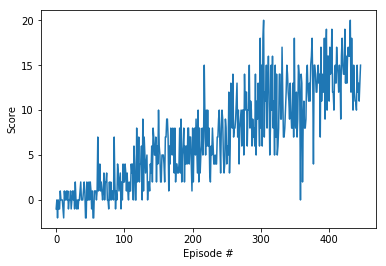

In [11]:
# Create an agent now
seed_num= 0
agent= Agent(state_size,action_size,seed_num)

# train now
scores = TrainDQN()

PlotScores(scores)

# watch agent 
WatchAgent(env, brain_name, agent)

env.close()